In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
image_path = "../Data_Group_Component_Task_1/Test/original_retinal_images/"
HE_mask_path = "../Data_Group_Component_Task_1/Test/masks_Haemorrhages/"
images = os.listdir(image_path)
HE_masks = os.listdir(HE_mask_path)
images.sort()
HE_masks.sort()
img_number = 6

In [3]:
def resize(img):
    ratio  = min([1152/img.shape[0], 1500/img.shape[1]])
    return cv2.resize(img,(int(img.shape[1]*ratio),int(img.shape[0]*ratio)), interpolation = cv2.INTER_CUBIC)

def rgb2Gray(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def clahe_equalized(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl1 = clahe.apply(img)
    return  cl1

def OTSU(img_gray):
    max_g = 0
    suitable_th = 0
    th_begin = 0
    th_end = 256
    for threshold in range(th_begin, th_end):
        bin_img = img_gray > threshold
        bin_img_inv = img_gray <= threshold
        fore_pix = np.sum(bin_img)
        back_pix = np.sum(bin_img_inv)
        if 0 == fore_pix:
            break
        if 0 == back_pix:
            continue
 
        w0 = float(fore_pix) / img_gray.size
        u0 = float(np.sum(img_gray * bin_img)) / fore_pix
        w1 = float(back_pix) / img_gray.size
        u1 = float(np.sum(img_gray * bin_img_inv)) / back_pix
        # intra-class variance
        g = w0 * w1 * (u0 - u1) * (u0 - u1)
        if g > max_g:
            max_g = g
            suitable_th = threshold
 
    return suitable_th


def vessel(img):
    dst = 255 - img
    clahe = cv2.createCLAHE(clipLimit=0.18,tileGridSize=(1,1))
    Ien = clahe.apply(dst)  
    kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
    final = cv2.subtract(Ien,opening)
    test =  OTSU(final)
    ret , binary = cv2.threshold (final ,test, test, cv2.THRESH_BINARY) 
    binary = cv2.medianBlur(binary, 3) 
    #binary = cv2.blur(binary,(5,5))
    return binary
    

In [4]:
image = image_path + images[img_number]
img = cv2.imread(image)
img = resize(img)
gray  = rgb2Gray(img)
T, B_Fov = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
b,g,r = cv2.split(img)
Ienhance = clahe_equalized(g)

Imedfilter = cv2.medianBlur(Ienhance,81)
Isub = cv2.subtract(Imedfilter,Ienhance)
Isub_filter = cv2.blur(Isub,(5,5))
Isub_filter = cv2.bitwise_and(Isub,B_Fov)
bestTh = OTSU(Isub_filter)
T,Idark_tep = cv2.threshold(Isub_filter, bestTh, 255, cv2.THRESH_BINARY)
sOP = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
Bdark = cv2.morphologyEx(Idark_tep,cv2.MORPH_OPEN,sOP)

Imed = cv2.medianBlur(Ienhance,131)
Isub1 = cv2.subtract(Imed,Ienhance)
Isub_filter1 = cv2.blur(Isub1,(5,5))
bestTh1 =  OTSU(Isub_filter1)
T,Idark_tep1 = cv2.threshold(Isub_filter1, bestTh1, 255, cv2.THRESH_BINARY)
Bdark1 = cv2.morphologyEx(Idark_tep1,cv2.MORPH_OPEN,sOP)

Bduel = cv2.bitwise_or(Bdark,Bdark1)

Ismooth = cv2.GaussianBlur(Ienhance,(7,7),0)
Ivessel = vessel(Ismooth)
kernel = np.ones((5, 5), np.uint8)
Ivessel = cv2.dilate(Ivessel, kernel)

Bduel = cv2.erode(Bduel,kernel)
same = cv2.bitwise_and(Ivessel,Bduel)
result = cv2.subtract(Bduel,same)
sOP6 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
result = cv2.morphologyEx(result,cv2.MORPH_OPEN,sOP6)
result = cv2.erode(result,kernel)

sOP10 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
result1 = cv2.morphologyEx(result,cv2.MORPH_OPEN,sOP10)

result = cv2.bitwise_or(result,result1)
result =  cv2.dilate(result, kernel)

# plt.imshow(result ,"gray")
# plt.show()

In [5]:
def evaluation(image, mask):
    
    zeros_list_img, one_list_img, zeros_list_mk, one_list_mk = [], [], [], []
    
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            val_mk = mask[i][j]
            val_img  = image[i][j]
            if val_mk == 0:
                zeros_list_mk.append((i,j))
            else:
                one_list_mk.append((i,j))
            if val_img == 0:
                zeros_list_img.append((i,j))
            else:
                one_list_img.append((i,j))
    #print(len(one_list_img))
    TP = len(set(one_list_img).intersection(set(one_list_mk)))
    TN = len(set(zeros_list_img).intersection(set(zeros_list_mk)))
    FP = len(set(one_list_img).intersection(set(zeros_list_mk)))
    FN = len(set(zeros_list_img).intersection(set(one_list_mk)))
    TPR = TP/(FN + TP)
    TNR = TN/(TN + FP)
    P = TP/(TP + FP)
    R = TP/(TP + FN)
    F = 2*(R*P/(R + P))
    JSC = TP/(TP + FP + FN)
    DSC = 2*(TP/(FP + 2*TP + FN))
    return TPR, TNR, F, JSC, DSC

result:


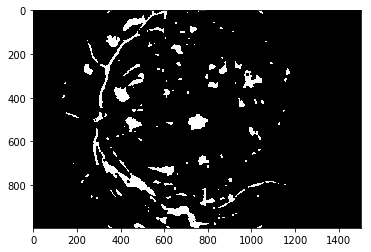

masks_Haemorrhages:


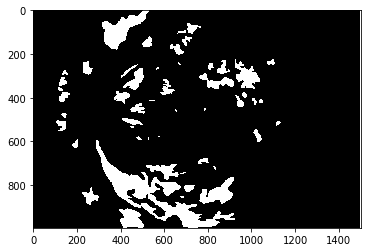

------------------------
JSC = 0.2647096305900475


In [6]:
mask = HE_mask_path + HE_masks[6]
mk = cv2.imread(mask)
mk = resize(mk)
mk = rgb2Gray(mk)

print('result:')
plt.imshow(result ,"gray")
plt.show()

T, mk = cv2.threshold(mk, 0, 255, cv2.THRESH_BINARY)
print('masks_Haemorrhages:')
plt.imshow(mk,"gray")
plt.show()

print('------------------------')
TPR, TNR, F, JSC, DSC = evaluation(result, mk)
print('JSC = ', end = '')
print(JSC)